# Guassian mixture intra-song clustering for identification of "main" beats

Code for doing tests

In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks, get_beat_data, get_audio_data
from groove.embedding import bar_embedding, load_bar_embedding, load_bar_embedding_total, bar_embedding_total, segmented_smooth_power
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks, get_beat_data, get_audio_data
from groove.intraclustering import get_ellipse_patch, get_patches, winnow_gm_components, ellipse_contains_points, find_closest_indices, bic_winnow_gm_components
import groove, groove.embedding, groove.downbeats


def simulate_num_components(data, num_trials, confidence_limit=0.9, cluster_threshold=0.2, overlap_allowance=0.1, use_weights=False):
    counts = {}
    for _ in range(num_trials):
        n_components = winnow_gm_components(data, confidence_limit=confidence_limit, cluster_threshold=cluster_threshold, overlap_allowance=overlap_allowance, use_weights=use_weights).means_.shape[0]
        if n_components in counts:
            counts[n_components] += 1
        else:
            counts[n_components] = 1
    return counts


def do_clustering(data, method='naive', max_clusters=5, simulations_per_level=3, confidence_limit=0.9, cluster_threshold=0.2, overlap_allowance=0.1, use_weights=False, verbose=False):
    if method == 'score':
        gm = bic_winnow_gm_components(data, max_clusters=max_clusters, simulations_per_level=simulations_per_level, verbose=verbose)
    else:
        gm = winnow_gm_components(data, simulations_per_level=simulations_per_level, confidence_limit=confidence_limit, cluster_threshold=cluster_threshold, overlap_allowance=overlap_allowance, use_weights=use_weights, verbose=verbose)
    print(f"Weights: {gm.weights_}")

    pca = PCA(n_components=2)
    pca.fit(data)
    print(f"PCA values: {pca.singular_values_}")

    return gm, pca


def do_projected_plot(gm, pca, data, confidence=0.9, data_list=None, file_list=None):

    red_data = pca.transform(data)
    patches, _ = get_patches(gm, confidence=confidence, pts=data, pca=pca)

    # Get axes min and max
    xlim = np.abs(red_data[:,0]).max() * 1.1
    ylim = np.abs(red_data[:,1]).max() * 1.1

    plt.figure(figsize=(8,8))
    ax = plt.gca()
    ax.set_xlim([-xlim, xlim])
    ax.set_ylim([-ylim, ylim])

    if data_list != None:
        cmap = mpl.colormaps['gist_rainbow'](np.linspace(0, 1, len(data_list)))
        #plt.cm.get_cmap('hsv', len(data_list)+1)

        running_total = 0
        legend_patches = []
        for i, d in enumerate(data_list):
            plt.scatter(red_data[running_total:running_total + d.shape[0],0], red_data[running_total:running_total + d.shape[0],1], alpha=0.5, color=cmap[i], s=3)
            running_total += d.shape[0]
            if file_list != None:
                legend_patches.append(mpatches.Patch(color=cmap[i], label=file_list[i][0]))
        if file_list != None:
            ax.legend(handles=legend_patches)
    else:
        plt.scatter(red_data[:,0], red_data[:,1], alpha=0.7)
    
    for p in patches:
        ax.add_patch(p)

    return patches


from IPython.display import Audio
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks
import librosa
from typing import Callable

def do_bar_sample(indices, file, process: Callable, ext="mp3"):
    raw_measures, proc_measures, sr = get_measures(file, process, ext)
    for i in indices:
        raw, proc = raw_measures[i], proc_measures[i]
        #beat_frames = get_beat_frames([proc], sr, beat_peaks)[0][0]
        #clicks = librosa.clicks(times=beat_frames/sr, length=raw.shape[0], sr=sr)


        plt.figure(figsize=(20, 4))
        #plt.plot(raw)
        plt.plot(proc)
        #plt.scatter(beat_frames, np.zeros(beat_frames.shape), marker='o', color='red', zorder=10)
        display(Audio(data=raw, rate=sr))
        #display(Audio(data=raw + clicks, rate=sr))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Clustering single song

Num components: 1
Converged? True
Log-likelihood: 859.2316243788727
Num components: 1
Converged? True
Log-likelihood: 859.2316243788727
Num components: 1
Converged? True
Log-likelihood: 859.2316243788727
BIC: [859.23162438 859.23162438 859.23162438], selecting index 0
Num components: 2
Converged? True
Log-likelihood: 865.5035669745491
Num components: 2
Converged? True
Log-likelihood: 865.5035669745491
Num components: 2
Converged? True
Log-likelihood: 865.5035669745491
BIC: [865.50356697 865.50356697 865.50356697], selecting index 0
Num components: 3
Converged? True
Log-likelihood: 870.0286169826478
Num components: 3
Converged? True
Log-likelihood: 870.8341797198464
Num components: 3
Converged? True
Log-likelihood: 870.9856215035161
BIC: [870.02861698 870.83417972 870.9856215 ], selecting index 2
Num components: 4
Converged? True
Log-likelihood: 874.8571955216723
Num components: 4
Converged? True
Log-likelihood: 872.782383248741
Num components: 4
Converged? True
Log-likelihood: 874.5983

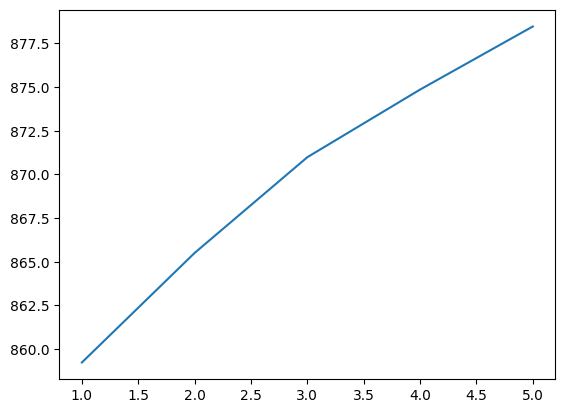

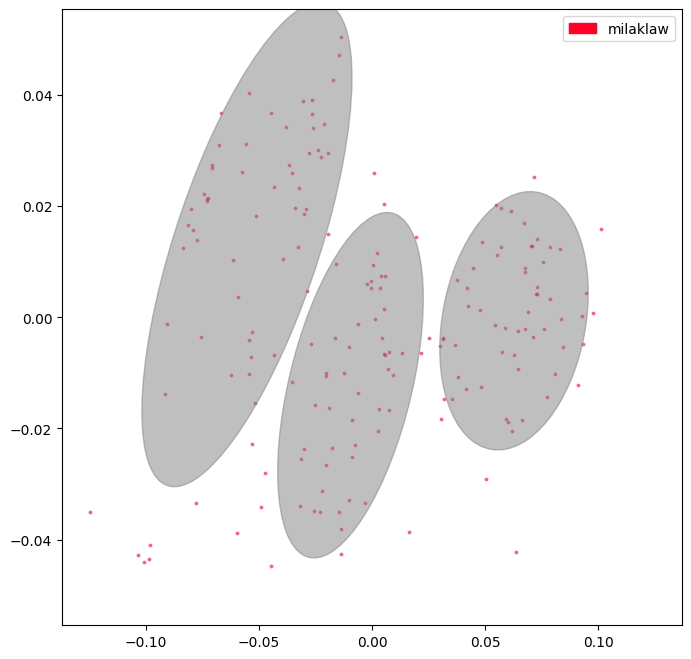

In [68]:
#proc_fn = groove.embedding.smooth_power
proc_fn = groove.embedding.segmented_smooth_power

divs = np.array([3, 4, 6, 8, 9, 12, 15, 16, 18, 20, 21, 24])
wts = 1/np.sqrt(divs)

#file_list = ['milaklaw', '06 Encore A', 'lms', ('09 D\'Angelo - Spanish Joint', 'm4a'), ('03 All the Pretty Girls', 'm4a')]
#file_list = [('03 All the Pretty Girls', 'm4a')]
file_list = ['milaklaw']
#file_list = [('09 D\'Angelo - Spanish Joint', 'm4a')]
#file_list = ['06 Encore A']

# Add extension
for i in range(len(file_list)):
    if type(file_list[i]) is not tuple:
        file_list[i] = (file_list[i], "mp3")

data_list = []
file_indices_list = []
indices_list = []
for i, (file, ext) in enumerate(file_list):
    data_list.append(load_bar_embedding_total(file, divisions=divs, weights=wts, process=proc_fn, kernel_width=30, ext=ext))
    file_indices_list.append(np.full((data_list[i].shape[0],), i))
    indices_list.append(np.arange(data_list[i].shape[0]))

# Data, the index in file_list that the data came from, and the index inside its sublist
data = np.concatenate(data_list, axis=0)
data_file_inds = np.concatenate(file_indices_list, axis=0)
data_inds = np.concatenate(indices_list, axis=0)


c = .8
gm, pca = do_clustering(data, method='score', verbose=True)

do_projected_plot(gm, pca, data, c, data_list=data_list, file_list=file_list)

Samples from milaklaw


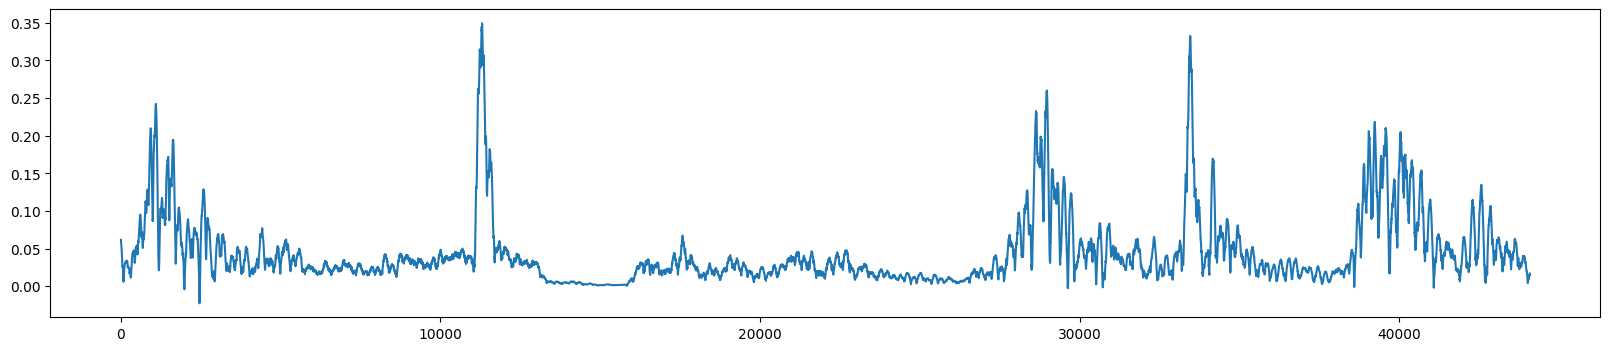

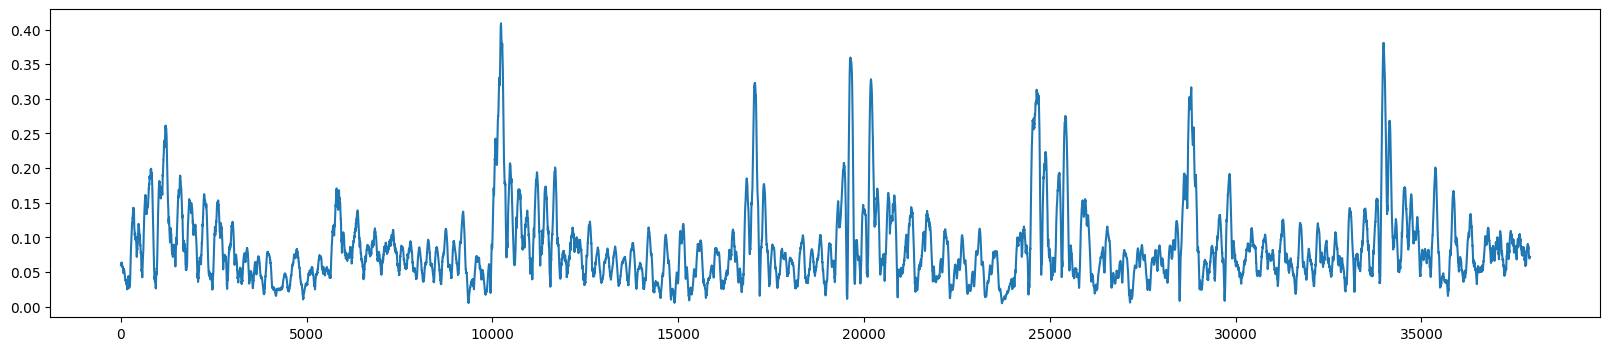

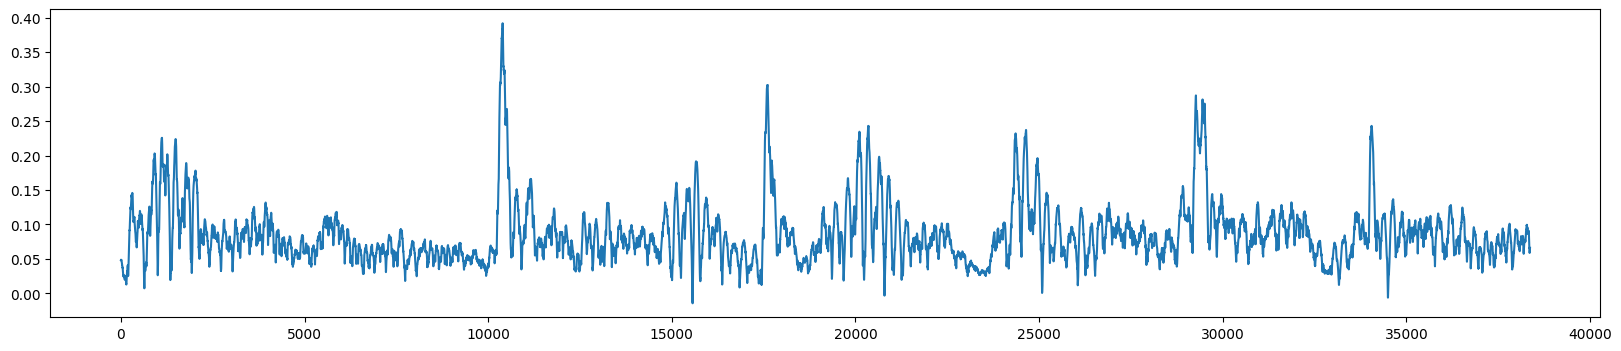

In [69]:
inds = find_closest_indices(gm.means_, data)

for i in range(len(file_list)):
    print(f"Samples from {file_list[i][0]}")
    do_bar_sample(data_inds[inds][data_file_inds[inds] == i], file_list[i][0], smooth_power, ext=file_list[i][1])
    print("")

# Clustering multiple songs

Load the file and process data using the embedding

In [70]:
proc_fn = groove.embedding.smooth_power
#proc_fn = groove.embedding.segmented_smooth_power

divs = np.array([3, 4, 6, 8, 9, 12, 15, 16, 18, 20, 21, 24])
wts = 1/np.sqrt(divs)


file_list = ['milaklaw', '06 Encore A', 'lms', ('09 D\'Angelo - Spanish Joint', 'm4a'), ('03 All the Pretty Girls', 'm4a')]

# Add extension
for i in range(len(file_list)):
    if type(file_list[i]) is not tuple:
        file_list[i] = (file_list[i], "mp3")

data_list = []
file_indices_list = []
indices_list = []
for i, (file, ext) in enumerate(file_list):
    data_list.append(load_bar_embedding_total(file, divisions=divs, weights=wts, process=proc_fn, kernel_width=30, ext=ext))
    file_indices_list.append(np.full((data_list[i].shape[0],), i))
    indices_list.append(np.arange(data_list[i].shape[0]))

# Data, the index in file_list that the data came from, and the index inside its sublist
data = np.concatenate(data_list, axis=0)
data_file_inds = np.concatenate(file_indices_list, axis=0)
data_inds = np.concatenate(indices_list, axis=0)

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?
/home/harrison/erdos/groove_gang/groove/embedding.py:303: UserWarning: PySoundFile failed. Trying audioread instead.
  embeds[i] = embeds[i] * weights[i]
/home/harrison/erdos/groove_gang/venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/home/harrison/erdos/groove_gang/groove/embedding.py:303: UserWarning: PySoundFile failed. Trying audioread instead.
  embeds[i] = embeds[i] * weights[i]
/home/harrison/erdos/groove_gang/venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Some rules for choosing the number of components:
1) Start with some number of components.
2) If overlaps between the 95%ile circles contain more than 10% of points, we should reduce.
3) If any circles don't cover 20%, we reduce.

Run some simulations on the number of components.

In [ ]:
#simulate_num_components(data, 100)

For visualization, PCA the top two components and project the clusters down

Num components: 1
Converged? True
Log-likelihood: 828.711243131479
Num components: 1
Converged? True
Log-likelihood: 828.711243131479
Num components: 1
Converged? True
Log-likelihood: 828.711243131479
BIC: [828.71124313 828.71124313 828.71124313], selecting index 0
Num components: 2
Converged? True
Log-likelihood: 837.1083856897137
Num components: 2
Converged? True
Log-likelihood: 837.1083856897137
Num components: 2
Converged? True
Log-likelihood: 837.1083856897137
BIC: [837.10838569 837.10838569 837.10838569], selecting index 0
Num components: 3
Converged? True
Log-likelihood: 843.2508541877487
Num components: 3
Converged? True
Log-likelihood: 843.2508541877487
Num components: 3
Converged? True
Log-likelihood: 843.626501678069
BIC: [843.25085419 843.25085419 843.62650168], selecting index 2
Num components: 4
Converged? True
Log-likelihood: 847.2248401496512
Num components: 4
Converged? True
Log-likelihood: 847.1420084967122
Num components: 4
Converged? True
Log-likelihood: 847.2119171

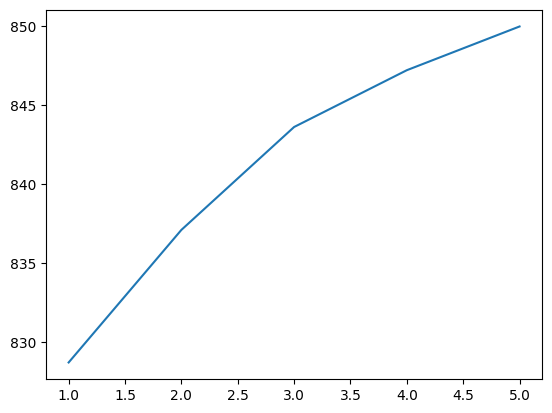

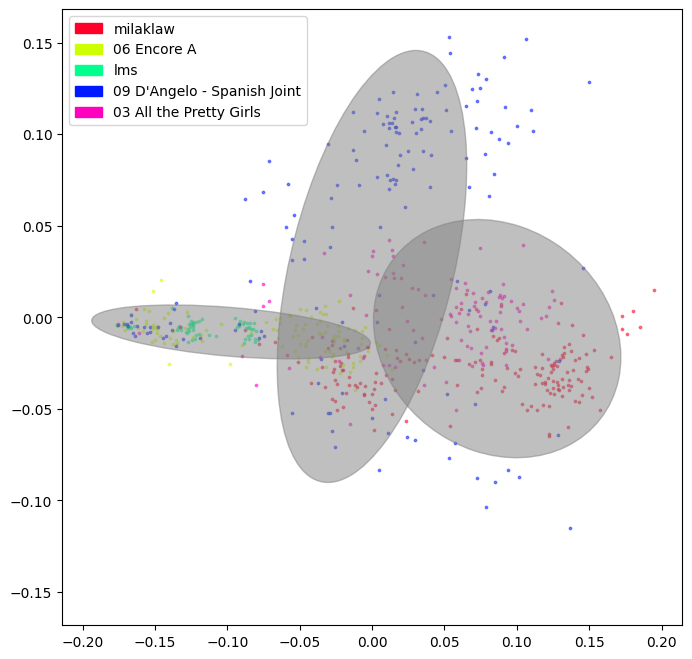

In [71]:
#c = .8
#gm, pca = do_clustering(data, confidence_limit=c, cluster_threshold=0.3, overlap_allowance=0.2, use_weights=False, verbose=True)

c = .8
#gm, pca = do_clustering(data, method='naive', max_clusters=20, confidence_limit=c, cluster_threshold=0.3/len(file_list), overlap_allowance=1, use_weights=False, verbose=True)
gm, pca = do_clustering(data, method='score', verbose=True)

do_projected_plot(gm, pca, data, c, data_list=data_list, file_list=file_list)

Pick the measures closest to the means of each cluster and play the audio.

Samples from milaklaw



Samples from 06 Encore A


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?



Samples from lms

Samples from 09 D'Angelo - Spanish Joint


/home/harrison/erdos/groove_gang/groove/downbeats.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(f'inputs/{file}.{ext}')
/home/harrison/erdos/groove_gang/venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)



Samples from 03 All the Pretty Girls


/home/harrison/erdos/groove_gang/groove/downbeats.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(f'inputs/{file}.{ext}')
/home/harrison/erdos/groove_gang/venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


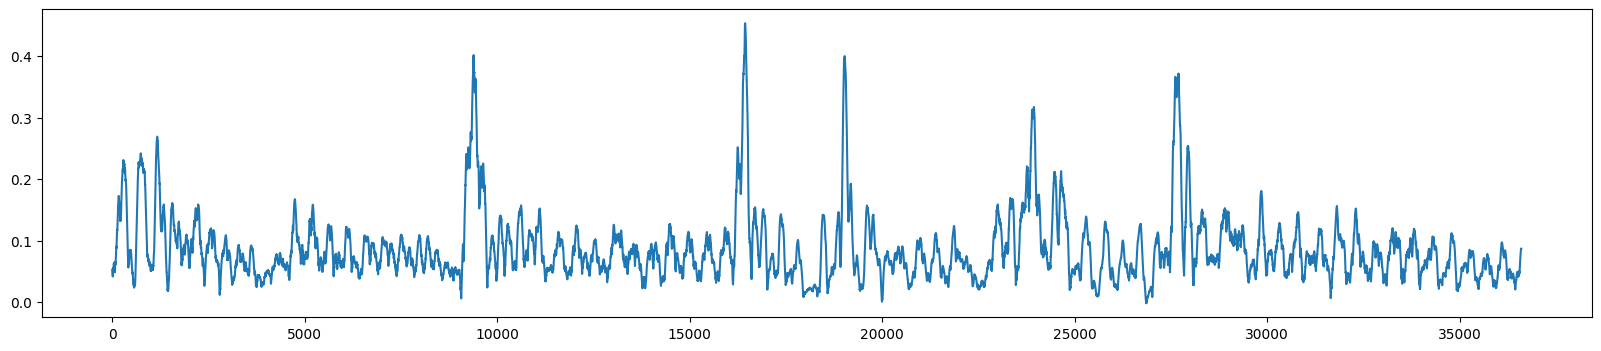

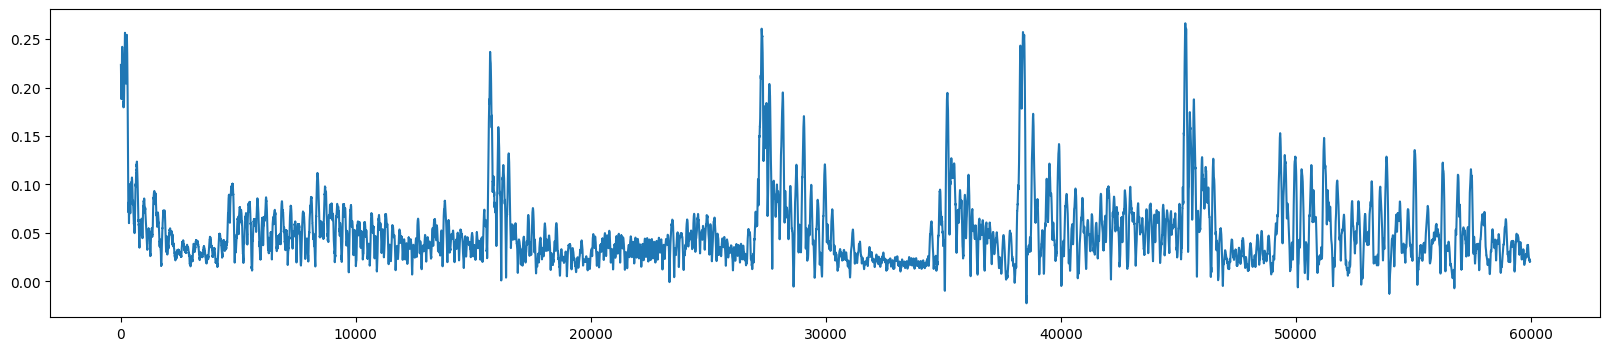

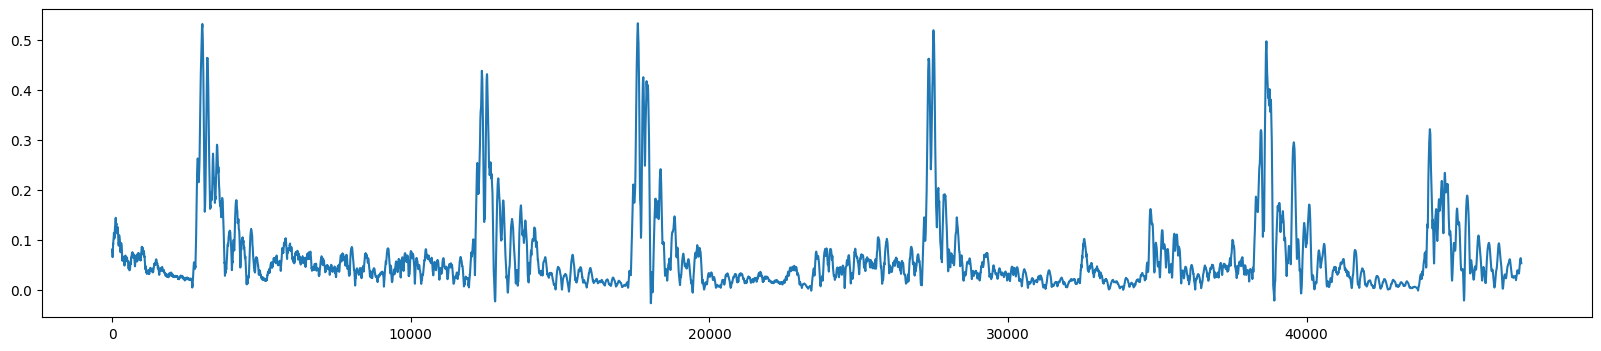

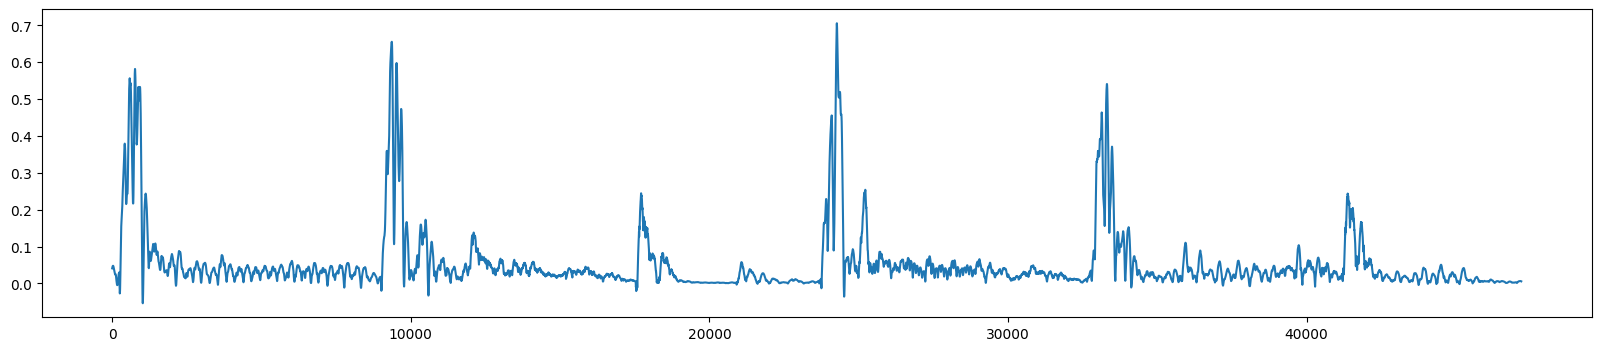

In [44]:
inds = find_closest_indices(gm.means_, data)

for i in range(len(file_list)):
    print(f"Samples from {file_list[i][0]}")
    do_bar_sample(data_inds[inds][data_file_inds[inds] == i], file_list[i][0], smooth_power, ext=file_list[i][1])
    print("")

# Selecting top cluster from each song

In [72]:
proc_fn = groove.downbeats.smooth_power

divs = np.array([3, 4, 6, 8, 9, 12, 15, 16, 18, 20, 21, 24])
wts = 1/np.sqrt(divs)


file_list = ['milaklaw', '06 Encore A', 'lms', ('09 D\'Angelo - Spanish Joint', 'm4a'), ('03 All the Pretty Girls', 'm4a')]

# Add extension
for i in range(len(file_list)):
    if type(file_list[i]) is not tuple:
        file_list[i] = (file_list[i], "mp3")

data_list = []
for i, (file, ext) in enumerate(file_list):
    data_list.append(load_bar_embedding_total(file, divisions=divs, weights=wts, process=segmented_smooth_power, kernel_width=30, ext=ext))

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?
/home/harrison/erdos/groove_gang/groove/embedding.py:303: UserWarning: PySoundFile failed. Trying audioread instead.
  embeds[i] = embeds[i] * weights[i]
/home/harrison/erdos/groove_gang/venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/home/harrison/erdos/groove_gang/groove/embedding.py:303: UserWarning: PySoundFile failed. Trying audioread instead.
  embeds[i] = embeds[i] * weights[i]
/home/harrison/erdos/groove_gang/venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Clustering ('milaklaw', 'mp3')
Num components: 1
Converged? True
Log-likelihood: 859.2316243788727
Num components: 1
Converged? True
Log-likelihood: 859.2316243788727
Num components: 1
Converged? True
Log-likelihood: 859.2316243788727
BIC: [859.23162438 859.23162438 859.23162438], selecting index 0
Num components: 2
Converged? True
Log-likelihood: 865.5035669745491
Num components: 2
Converged? True
Log-likelihood: 865.5035669745491
Num components: 2
Converged? True
Log-likelihood: 865.5035669745491
BIC: [865.50356697 865.50356697 865.50356697], selecting index 0
Num components: 3
Converged? True
Log-likelihood: 870.9856215035161
Num components: 3
Converged? True
Log-likelihood: 870.8341797198464
Num components: 3
Converged? True
Log-likelihood: 870.8341797198464
BIC: [870.9856215  870.83417972 870.83417972], selecting index 0
Num components: 4
Converged? True
Log-likelihood: 875.3743524518237
Num components: 4
Converged? True
Log-likelihood: 874.0697247622697
Num components: 4
Converge

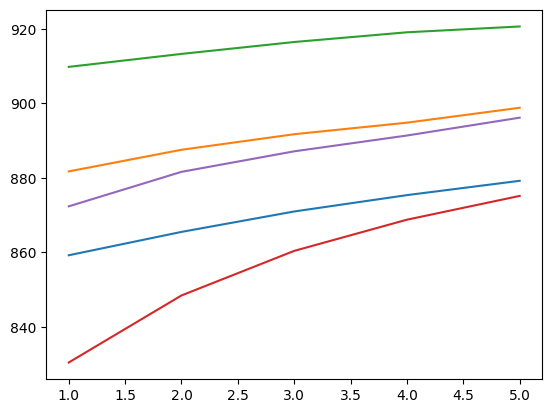

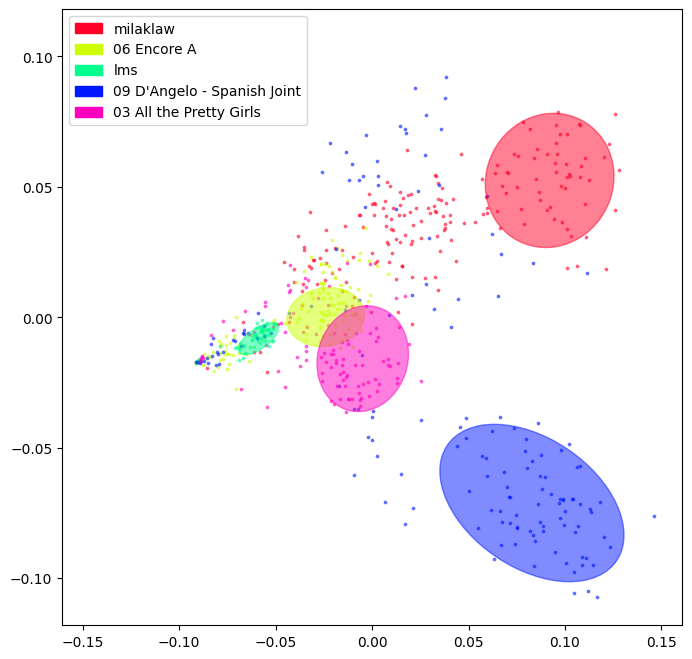

In [73]:
gms = []
pcas = []

c = .8
for i, data in enumerate(data_list):
    print(f"Clustering {file_list[i]}")
    #gm, _ = do_clustering(data, simulations_per_level=5, confidence_limit=c, cluster_threshold=0.3, overlap_allowance=0.2, use_weights=False, verbose=True)
    gm, _ = do_clustering(data, method='score', simulations_per_level=3, verbose=True)
    gms.append(gm)
    print("")

all_data = np.concatenate(data_list, axis=0)
pca = PCA(2)
pca.fit(all_data)
red_data = []
for d in data_list:
    red_data.append(pca.transform(d))

all_red_data = np.concatenate(red_data, axis=0)

# Get axes min and max
xlim = np.abs(all_red_data[:,0]).max() * 1.1
ylim = np.abs(all_red_data[:,1]).max() * 1.1

plt.figure(figsize=(8,8))
ax = plt.gca()
ax.set_xlim([-xlim, xlim])
ax.set_ylim([-ylim, ylim])


# Plot the data
cmap = mpl.colormaps['gist_rainbow'](np.linspace(0, 1, len(data_list)))
for i in range(len(data_list)):
    plt.scatter(red_data[i][:,0], red_data[i][:,1], alpha=0.5, color=cmap[i], s=3)

print("====================\n")

patches = []
legend_patches = []
for i, gm in enumerate(gms):
    p, _ = get_patches(gm, confidence=c, pts=data_list[i], pca=pca)
    best_cluster = gm.weights_.argmax()
    patches.append(p[best_cluster])
    patches[-1].set_color(cmap[i])
    legend_patches.append(mpatches.Patch(color=cmap[i], label=file_list[i][0]))

    # Check how many points from other songs this contains
    for j in range(len(data_list)):
        if i == j:
            continue
        bad_containment = ellipse_contains_points(gm.means_[best_cluster], gm.covariances_[best_cluster], data_list[j], confidence=c)
        print(f"{file_list[i]} contains {bad_containment.sum().item()} measures from {file_list[j]} out of {bad_containment.shape[0]}, i.e. {bad_containment.sum().item()/bad_containment.shape[0] * 100}%.")
    print("")


ax.legend(handles=legend_patches)
for p in patches:
     ax.add_patch(p)



# Actual usage

In [12]:
import numpy as np
from groove.downbeats import smooth_power
from groove.embedding import load_bar_embedding_total
from groove.intraclustering import get_primary_gaussian_mean

file = '06 Encore A'
ext = 'mp3'

divs = np.array([3, 4, 6, 8, 9, 12, 16])
wts = 1/np.sqrt(divs)
data = load_bar_embedding_total(file, divs, wts, smooth_power, ext=ext, concatenate=True)
measure = get_primary_gaussian_mean(data)

print(measure.shape)


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


(58,)
